# Variational method for $^4 \text{He}$

In [1]:
from IPython.display import Latex

from itertools import product
import time

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = (9, 6)

from numba import njit
import numpy as np
from scipy.constants import hbar, physical_constants
from scipy.constants import k as kB # Boltzmann constant
from scipy.optimize import curve_fit

from matplotlib.backends.backend_pdf import PdfPages

## Units

In [2]:
epsilon = 10.22 # K (Kelvin)
sigma = 0.2556 # nm (nanometres)

m = 4.002603254 # amu (atomic mass unit)
amu = physical_constants['atomic mass constant'][0] # Kg

# alpha := hbar^2 / 2m in epsilon-sigma units
alpha = hbar**2 / (2*m*amu) / (epsilon*kB) / (sigma**2*1e-18)

Latex(f'$\\alpha$ = {alpha:.3f}')

<IPython.core.display.Latex object>

## Fcc lattice

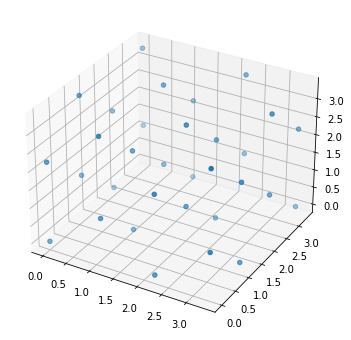

In [3]:
def fcc_lattice(N, a):
    """
    Return a numpy array for a fcc-lattice, where the lattice is a cube of
    elementary cells. Then N must be of the type: N = 4 * n**3, where n is the 
    number of cells per side of the cubic box. "a" is the lattice parameter
    """
    lattice = np.zeros((N, 3))
    
    # first unit cell position
    unit_cell = np.array([[0,   0,   0],
                          [a/2, a/2, 0],
                          [0,   a/2, a/2],
                          [a/2, 0,   a/2]])
    
    # number of cells in the box
    n = N // 4
    
    # number of cells per side
    cells_per_side = round(n**(1/3))
    
    # coordinates of cells in the box
    cells_coordinates = product(range(cells_per_side), repeat=3)
    for i, coords in enumerate(cells_coordinates):
        
        # cell translation matrix
        R = np.zeros((4, 3))

        R[:, 0] = int(coords[0]) * a
        R[:, 1] = int(coords[1]) * a
        R[:, 2] = int(coords[2]) * a
        
        lattice[4*i:4*(i+1)] = unit_cell + R
        
    return lattice

N = 32

rho0 = 21.85 * sigma**3
L = (N / rho0)**(1/3)

conf = fcc_lattice(N, L/2)

pdf = PdfPages('lattice.pdf')
ax = plt.axes(projection='3d')

ax.scatter(conf[:, 0], conf[:, 1], conf[:, 2])

pdf.savefig()
pdf.close()

## Monte Carlo routines

In [4]:
@njit # compute distance between atom i and atom j
def dist(r_i, r_j, L):
    r_ij = r_j - r_i - L * np.rint((r_j - r_i) / L)
    r_ij = np.sum(r_ij**2)**0.5
    return r_ij


@njit # Lennard-Jones potential
def V_lj(r):
    return 4 * ((1/r)**12 - (1/r)**6)


@njit # Jastrow wave function
def wf(conf, b, L):
    # number of particles
    N = conf.shape[0]
    
    U = 0
    for i in range(N):
        for j in range(i):
            # compute U(r_ij)
            r_ij = dist(conf[i], conf[j], L)
            U += (b / r_ij)**5
            
    return np.exp(-0.5 * U)

In [5]:
@njit # proper and Jackson-Feenberg local kinetic energy
def T_local(conf, b, L):
    # number of particles
    N = conf.shape[0]
    
    # laplacian and gradient of U
    lap_U = 0
    grad_U2 = 0
    
    for l in range(N):
        # gradient l
        grad_U = np.zeros(3)
        for i in range(N):
            if i != l:
                # R_il := vector of r_il
                R_il = conf[l] - conf[i] - L * np.rint((conf[l] - conf[i]) / L)
                r_il = dist(conf[i], conf[l], L)
                
                # cutoff radius
                if r_il < L/2:
                    # d2U/dr2 + 2/r * dU/dr
                    lap_U += 20 * b**5 / r_il**7

                    # dU/dr * \vec{r} / r
                    grad_U += -5 * b**5 / r_il**7 * R_il

        # squared gradient
        grad_U2 += np.sum(grad_U**2)

    # return T, T_JF
    return alpha * (lap_U/2 - grad_U2/4), alpha/4 * lap_U


@njit # local energy
def E_local(conf, b, L):
    # number of particles
    N = conf.shape[0]
    
    V = 0
    # compute two-body potential
    for i in range(N):
        for j in range(i):
            r_ij = dist(conf[i], conf[j], L)
            # cutoff radius
            if r_ij < L/2:
                V += V_lj(r_ij)

    T, T_JF = T_local(conf, b, L)
    return T, V, T_JF

In [6]:
@njit # Monte Carlo step
def MC_step(conf, delta, L, b):
    # number of particles
    N = conf.shape[0]
    E = np.zeros((7, 10))
    # sample random particles to move
    to_move = np.random.choice(N, size=N//4, replace=False)
    
    # build proposal for the step
    proposal = np.zeros(conf.shape)
    proposal[to_move] = delta * (np.random.rand(N//4, conf.shape[1]) - 0.5)
    proposal = proposal + conf
    
    # apply pbc
    proposal = proposal - L * np.floor(proposal / L)

    # transition confidence
    p = wf(proposal, b, L)**2 / wf(conf, b, L)**2
    # sample uniform random variable
    eta = np.random.rand()
    
    # return 1 if is a new configuration, 0 otherwise
    if p > eta:
        return proposal, 1
    return conf, 0

In [7]:
@njit # compute autocorrelation
def autocorrelation(E):
    # autocorrelation coefficient
    c_tau = np.zeros(250)
            
    # iterate over tau
    for tau in range(250):
        for i in range(len(E) - tau):
            c_tau[tau] += E[i] * E[i+tau] / (len(E) - tau)

    # compute coefficent for every tau
    c_tau = (c_tau - np.mean(E)**2) / np.var(E)
    
    return int(np.sum(c_tau))

In [8]:
@njit # energy long range correction
def E_LRC(rc, rho, b):
    T_LRC = alpha * rho * 5 * np.pi * b**5 / rc**4
    V_LRC = 8/3 * np.pi * rho * (1 / (3*rc**9) - 1 / rc**3)
    return (V_LRC + T_LRC) * epsilon


@njit # variational step
def Var_step(conf, b, L):
    # number of particles
    N = conf.shape[0]
    # init delta for MC proposal
    delta = L / 10
    11# accepted proposal (forward_steps)
    fw_steps = 0
    
    # store energy values to compute autocorrelation
    # T and T_JF are saved for afterwards conmparison
    # E = [T, V, T_JF]
    E = np.zeros((10000, 3))
    
    # acceptance ratio
    gamma = np.zeros(10)
    
    ######## EQUILIBRATION ########
    
    # first 15k steps to update delta and reach equilibrium
    # last 10k steps to compute correlation lenght
    for i in range(25000):

        # every 1000 steps update delta, up to 15k steps
        if (i % 1000 == 0) and (i < 15000) and (i > 0):
            # update delta
            if (fw_steps > 625) or (fw_steps < 375):
                delta = delta * (1 + 0.5*(fw_steps/1000 - 0.5))
            
            # reset forward steps counter
            fw_steps = 0
        
        # compute energy values for autocorrelation
        if (i >= 15000):
            E[i - 15000] = E_local(conf, b, L)
            
            if i % 1000 == 0:
                gamma[(i - 15000) // 1000] = fw_steps / 1000
                fw_steps = 0

        # compute MC step
        conf, is_new = MC_step(conf, delta, L, b)
        fw_steps += is_new
    
    # energy values to compute autocorrelation
    T, V, T_JF = E[:, 0], E[:, 1], E[:, 2]
    
    # compute autocorrelation
    tau_bar = autocorrelation(T + V)
    
    ####### INTEGRAL EVALUATION ########
    
    # integration steps
    int_N = int(50e3)
    E = np.zeros((int_N, 3))
    
    for i in range(tau_bar*int_N):
        conf, is_new = MC_step(conf, delta, L, b)
        # every tau_bar steps compute non correlated energy values 
        if i % tau_bar == 0:
            E[i // tau_bar] = E_local(conf, b, L)
            
    T, V, T_JF = E[:, 0], E[:, 1], E[:, 2]
    
    delta_E = np.std(T + V) * epsilon / N / np.sqrt(int_N)
    E = np.mean(T + V) * epsilon / N
    
    delta_T = np.std(T) * epsilon / N / np.sqrt(int_N)
    T = np.mean(T) * epsilon / N
    
    delta_V = np.std(V) * epsilon / N / np.sqrt(int_N)
    V = np.mean(V) * epsilon / N
    
    delta_T_JF = np.std(T_JF) * epsilon / N / np.sqrt(int_N)
    T_JF = np.mean(T_JF) * epsilon / N
    
    delta_gamma = np.std(gamma)
    gamma = np.mean(gamma)
    
    # energy with long range correction
    E_wLRC = T_JF + V + E_LRC(L/2, N / L**3, b)
    delta_E_wLRC = delta_T_JF + delta_V

    return E, delta_E, T, delta_T, V, delta_V, T_JF, delta_T_JF, E_wLRC, delta_E_wLRC, gamma, delta_gamma

## VMC at $\rho_0$

In [9]:
N = 32

rho0 = 21.86 * sigma**3
L = (N / rho0)**(1/3)

conf = fcc_lattice(N, L/2)
E_rho0 = np.zeros((16, 12))

var_b = np.linspace(1.1, 1.25, 16)

for i, b in enumerate(var_b):
    E_rho0[i] = Var_step(conf, b, L)

In [10]:
ind_min_E = np.argmin(E_rho0[:, 0])
print(f'b = {np.linspace(1.1, 1.25, 16)[ind_min_E]}')

label = ['E_{{\\rho_0}}', 'T', 'V', 'T_{JF}', 'E_{{LRC}}', '\gamma']
for i in range(6):
    display(Latex(f'${label[i]} = {E_rho0[ind_min_E][2*i]:.3f} \pm {E_rho0[ind_min_E][2*i+1]:.3f}$'))

b = 1.18


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [11]:
var_b = np.linspace(1.1, 1.25, 16)

ind_min_b = np.argmin(E_rho0[:, 8])
print(f'b = {var_b[ind_min_b]:.2f}')
Latex(f'$E_{{\\rho_0}}^{{LRC}} = {E_rho0[ind_min_b, 8]:.3f} \pm {E_rho0[ind_min_b, 9]:.3f}\ °K / atom$')

b = 1.17


<IPython.core.display.Latex object>

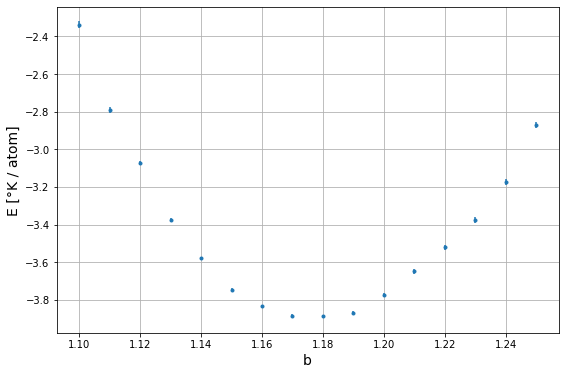

In [12]:
pdf = PdfPages('E_rho0.pdf')

plt.errorbar(var_b, E_rho0[:, 0], yerr=E_rho0[:, 1], fmt='.')

plt.xlabel('b', fontsize=14)
plt.ylabel('E [°K / atom]', fontsize=14)
plt.grid()

pdf.savefig()
pdf.close()

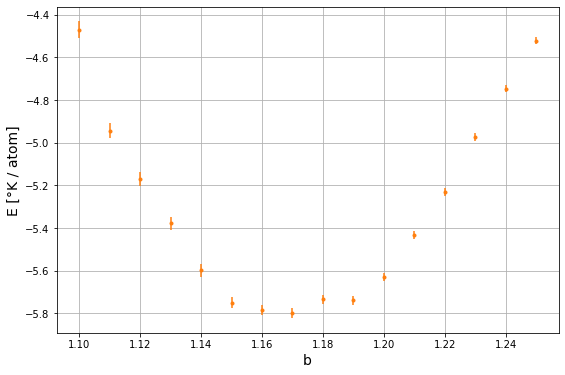

In [13]:
pdf = PdfPages('E_rho0_LRC.pdf')

plt.errorbar(var_b, E_rho0[:, 8], yerr=E_rho0[:, 9], fmt='.', label='$E_{{LRC}}$', color='tab:orange')

plt.xlabel('b', fontsize=14)
plt.ylabel('E [°K / atom]', fontsize=14)
plt.grid()

pdf.savefig()
pdf.close()

## VMC on $b$ and $\rho$

In [14]:
rhos = np.linspace(0.75, 1.05, 16) * rho0

E_rho = np.zeros((16, 13))
var_b = np.linspace(1.15, 1.19, 5)

for i, rho in enumerate(rhos):
    L = (N / rho)**(1/3)
    conf = fcc_lattice(N, L/2)
    
    E = np.zeros((5, 13))
    
    for j, b in enumerate(var_b):
        E[j, :12] = Var_step(conf, b, L)
        E[j, 12] = b
    
    E_rho[i] = E[np.argmin(E[:, 0])]

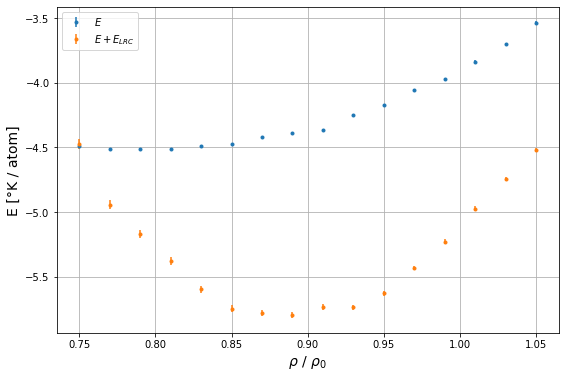

In [15]:
pdf = PdfPages('E_rho.pdf')

plt.errorbar(rhos/rho0, E_rho[:, 0], yerr=E_rho[:, 1], fmt='.',  label='$E$')
plt.errorbar(rhos/rho0, E_rho0[:, 8], yerr=E_rho0[:, 9], fmt='.', label='$E + E_{{LRC}}$')

plt.xlabel('$\\rho\ /\ \\rho_0$', fontsize=14)
plt.ylabel('E [°K / atom]', fontsize=14)
plt.legend()
plt.grid()

pdf.savefig()
pdf.close()

In [16]:
min_rho = np.argmin(E_rho[:, 8])

label = ['E_{{\\rho_0}}', 'T', 'V', 'T_{JF}', 'E_{{LRC}}', '\gamma']
for i in range(6):
    display(Latex(f'${label[i]} = {E_rho[min_rho][2*i]:.3f} \pm {E_rho[min_rho][2*i+1]:.3f}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Plotting example

In [19]:
@njit # compute autocorrelation
def plot_autocorrelation(E):
    # autocorrelation coefficient
    c_tau = np.zeros(250)
            
    # iterate over tau
    for tau in range(250):
        for i in range(len(E) - tau):
            c_tau[tau] += E[i] * E[i+tau] / (len(E) - tau)

    # compute mean for every tau
    c_tau = (c_tau - np.mean(E)**2) / np.var(E)
    
    return c_tau, int(np.sum(c_tau))


def Var_step_plot(conf, b, L):
    # number of particles
    N = conf.shape[0]
    # init delta for MC proposal
    delta = L / 10
    11# accepted proposal (forward_steps)
    fw_steps = 0
    
    # store energy values to compute autocorrelation
    # T and T_JF are saved for afterwards conmparison
    # E = [T, V, T_JF]
    E = np.zeros((10000, 3))
    
    # acceptance ratio
    gamma = np.zeros(10)
    
    ######## EQUILIBRATION ########
    
    # first 15k steps to update delta and reach equilibrium
    # last 10k steps to compute correlation lenght
    for i in range(25000):

        # every 1000 steps update delta, up to 15k steps
        if (i % 1000 == 0) and (i < 15000) and (i > 0):
            # update delta
            if (fw_steps > 625) or (fw_steps < 375):
                delta = delta * (1 + 0.5*(fw_steps/1000 - 0.5))
            
            # reset forward steps counter
            fw_steps = 0
        
        # compute energy values for autocorrelation
        if (i >= 15000):
            E[i - 15000] = E_local(conf, b, L)
            
            if i % 1000 == 0:
                gamma[(i - 15000) // 1000] = fw_steps / 1000
                fw_steps = 0

        # compute MC step
        conf, is_new = MC_step(conf, delta, L, b)
        fw_steps += is_new
    
    # energy values to compute autocorrelation
    T, V, T_JF = E[:, 0], E[:, 1], E[:, 2]
    
    # compute autocorrelation
    c_tau, tau_bar = plot_autocorrelation(T + V)
    
    ####### INTEGRAL EVALUATION ########
    
    for i in range(tau_bar*1000):
        conf, is_new = MC_step(conf, delta, L, b)
        # every tau_bar steps compute non correlated energy values 
        if i % tau_bar == 0:
            E[i // tau_bar] = E_local(conf, b, L)
            
    T, V, T_JF = E[:, 0], E[:, 1], E[:, 2]

    return (T + V)[:1000], T[:1000], V[:1000], T_JF[:1000], c_tau, tau_bar, delta, gamma

In [20]:
N = 32

rho0 = 21.86 * sigma**3
L = (N / (rho0))**(1/3)

conf = fcc_lattice(N, L/2)

plot_data = Var_step_plot(conf, 1.18, L)

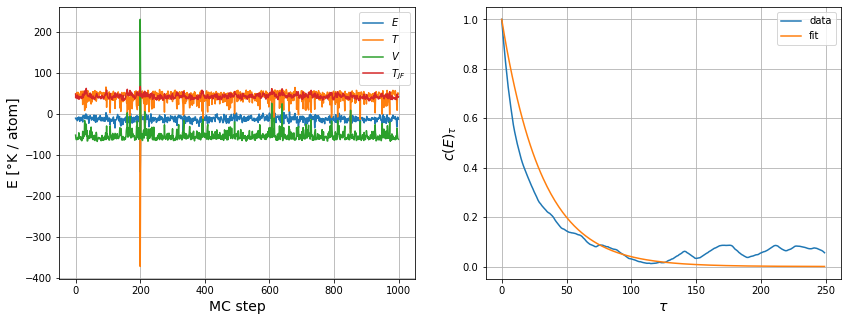

In [21]:
pdf = PdfPages('ex_plot.pdf')

plt.figure(figsize = (14, 5))

plt.subplot(122)

c_tau = lambda t, tau: np.exp(-t / tau)

plt.plot(range(250), plot_data[4], label='data')
plt.plot(range(250), c_tau(np.arange(250), int(np.sum(plot_data[4]))), label='fit')

plt.xlabel('$\\tau$', fontsize=14)
plt.ylabel('$c(E)_{{\\tau}}$', fontsize=14)
plt.legend()
plt.grid()

plt.subplot(121)

plt.plot(range(1000), plot_data[0], label='$E$')
plt.plot(range(1000), plot_data[1], label='$T$')
plt.plot(range(1000), plot_data[2], label='$V$')
plt.plot(range(1000), plot_data[3], label='$T_{{JF}}$')

plt.xlabel('MC step', fontsize=14)
plt.ylabel('E [°K / atom]', fontsize=14)
plt.legend()
plt.grid()

pdf.savefig()
pdf.close()

# Check periodic boundary conditions $N = 108$

In [22]:
N = 108

rho0 = 21.86 * sigma**3
L = (N / (rho0))**(1/3)

conf = fcc_lattice(N, L/3)

pbc_check = np.array(Var_step(conf, 1.17, L))

label = ['E_{{\\rho_0}}', 'T', 'V', 'T_{JF}', 'E_{{LRC}}', '\gamma']
for i in range(6):
    display(Latex(f'${label[i]} = {pbc_check[2*i]:.3f} \pm {pbc_check[2*i+1]:.3f}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [23]:
erg_to_K = 1e-7 / kB *1e-15
McMillan = (-0.781 * erg_to_K, 0.015 * erg_to_K)
Latex(f'McMillan $ E = {McMillan[0]:.3f} \pm {McMillan[1]:.3f}\ °K / atom$')

<IPython.core.display.Latex object>